# **Imports & supporting functions**

In [25]:
import sys
import os
import json
from skimage import io
import numpy as np
import time

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
!pip install utils

## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Mounting Failed.")

py_file_dir = '/content/drive/MyDrive/Colab Notebooks/project/'
sys.path.append(py_file_dir)
!ls '/content/drive/MyDrive/Colab Notebooks/project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
attr_dict.py  __init__.py	 mynn.py       __pycache__
config.py     misc.py		 myutils.py    rmi.py
hrnetv2.py    model_trained.pth  ocr_utils.py  rmi_utils.py


In [26]:
from myutils import get_trunk
from mynn import initialize_weights, Upsample, scale_as
from mynn import ResizeX
from myutils import get_trunk
from myutils import BNReLU, get_aspp
from myutils import make_attn_head
from ocr_utils import SpatialGather_Module, SpatialOCR_Module
from config import cfg
from rmi import RMILoss

def fmt_scale(prefix, scale):
    """
    format scale name

    :prefix: a string that is the beginning of the field name
    :scale: a scale value (0.25, 0.5, 1.0, 2.0)
    """

    scale_str = str(float(scale))
    scale_str.replace('.', '')
    return f'{prefix}_{scale_str}x'

# **Network archtecture**


In [27]:
class OCR_block(nn.Module):
    """
    Some of the code in this class is borrowed from:
    https://github.com/HRNet/HRNet-Semantic-Segmentation/tree/HRNet-OCR
    """
    def __init__(self, high_level_ch):
        super(OCR_block, self).__init__()

        ocr_mid_channels = cfg.MODEL.OCR.MID_CHANNELS
        ocr_key_channels = cfg.MODEL.OCR.KEY_CHANNELS
        #num_classes = cfg.DATASET.NUM_CLASSES
        num_classes = 2
        
        self.conv3x3_ocr = nn.Sequential(
            nn.Conv2d(high_level_ch, ocr_mid_channels,
                      kernel_size=3, stride=1, padding=1),
            BNReLU(ocr_mid_channels),
        )
        self.ocr_gather_head = SpatialGather_Module(num_classes)
        print('X')
        self.ocr_distri_head = SpatialOCR_Module(in_channels=ocr_mid_channels,
                                                 key_channels=ocr_key_channels,
                                                 out_channels=ocr_mid_channels,
                                                 scale=1,
                                                 dropout=0.05,
                                                 )
        self.cls_head = nn.Conv2d(
            ocr_mid_channels, num_classes, kernel_size=1, stride=1, padding=0,
            bias=True)
        
        self.aux_head = nn.Sequential(
            nn.Conv2d(high_level_ch, high_level_ch,
                      kernel_size=1, stride=1, padding=0),
            BNReLU(high_level_ch),
            nn.Conv2d(high_level_ch, num_classes,
                      kernel_size=1, stride=1, padding=0, bias=True)
        )

        if cfg.OPTIONS.INIT_DECODER:
            initialize_weights(self.conv3x3_ocr,
                               self.ocr_gather_head,
                               self.ocr_distri_head,
                               self.cls_head,
                               self.aux_head)

    def forward(self, high_level_features):
        feats = self.conv3x3_ocr(high_level_features)
        aux_out = self.aux_head(high_level_features)
        context = self.ocr_gather_head(feats, aux_out)
        ocr_feats = self.ocr_distri_head(feats, context)
        cls_out = self.cls_head(ocr_feats)
        return cls_out, aux_out, ocr_feats



In [28]:
class MscaleOCR(nn.Module):
    """
    OCR net
    """
    def __init__(self, num_classes, trunk='hrnetv2', criterion=None):
        super(MscaleOCR, self).__init__()
        self.criterion = criterion
        self.backbone, _, _, high_level_ch = get_trunk(trunk)
        # print(self.backbone.conv1)
        self.backbone.conv1 = nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.ocr = OCR_block(high_level_ch)
        self.scale_attn = make_attn_head(
            in_ch=cfg.MODEL.OCR.MID_CHANNELS, out_ch=1)


    def _fwd(self, x):
        x_size = x.size()[2:]

        _, _, high_level_features = self.backbone(x)
        cls_out, aux_out, ocr_mid_feats = self.ocr(high_level_features)
        attn = self.scale_attn(ocr_mid_feats)

        aux_out = Upsample(aux_out, x_size)
        cls_out = Upsample(cls_out, x_size)
        attn = Upsample(attn, x_size)

        return {'cls_out': cls_out,
                'aux_out': aux_out,
                'logit_attn': attn}

    def nscale_forward(self, inputs, scales):
        """
        Hierarchical attention, primarily used for getting best inference
        results.
        We use attention at multiple scales, giving priority to the lower
        resolutions. For example, if we have 4 scales {0.5, 1.0, 1.5, 2.0},
        then evaluation is done as follows:
              p_joint = attn_1.5 * p_1.5 + (1 - attn_1.5) * down(p_2.0)
              p_joint = attn_1.0 * p_1.0 + (1 - attn_1.0) * down(p_joint)
              p_joint = up(attn_0.5 * p_0.5) * (1 - up(attn_0.5)) * p_joint
        The target scale is always 1.0, and 1.0 is expected to be part of the
        list of scales. When predictions are done at greater than 1.0 scale,
        the predictions are downsampled before combining with the next lower
        scale.
        Inputs:
          scales - a list of scales to evaluate
          inputs - dict containing 'images', the input, and 'gts', the ground
                   truth mask
        Output:
          If training, return loss, else return prediction + attention
        """
        x_1x = inputs['images']

        assert 1.0 in scales, 'expected 1.0 to be the target scale'
        # Lower resolution provides attention for higher rez predictions,
        # so we evaluate in order: high to low
        scales = sorted(scales, reverse=True)

        pred = None
        aux = None
        output_dict = {}

        for s in scales:
            x = ResizeX(x_1x, s)
            outs = self._fwd(x)
            cls_out = outs['cls_out']
            attn_out = outs['logit_attn']
            aux_out = outs['aux_out']

            output_dict[fmt_scale('pred', s)] = cls_out
            if s != 2.0:
                output_dict[fmt_scale('attn', s)] = attn_out

            if pred is None:
                pred = cls_out
                aux = aux_out
            elif s >= 1.0:
                # downscale previous
                pred = scale_as(pred, cls_out)
                pred = attn_out * cls_out + (1 - attn_out) * pred
                aux = scale_as(aux, cls_out)
                aux = attn_out * aux_out + (1 - attn_out) * aux
            else:
                # s < 1.0: upscale current
                cls_out = attn_out * cls_out
                aux_out = attn_out * aux_out

                cls_out = scale_as(cls_out, pred)
                aux_out = scale_as(aux_out, pred)
                attn_out = scale_as(attn_out, pred)

                pred = cls_out + (1 - attn_out) * pred
                aux = aux_out + (1 - attn_out) * aux

        if self.training:
            assert 'gts' in inputs
            gts = inputs['gts']
            loss = cfg.LOSS.OCR_ALPHA * self.criterion(aux, gts) + \
                self.criterion(pred, gts)
            return loss
        else:
            output_dict['pred'] = pred
            return output_dict

    def two_scale_forward(self, inputs):
        """
        Do we supervised both aux outputs, lo and high scale?
        Should attention be used to combine the aux output?
        Normally we only supervise the combined 1x output
        If we use attention to combine the aux outputs, then
        we can use normal weighting for aux vs. cls outputs
        """
        assert 'images' in inputs
        x_1x = inputs['images']

        x_lo = ResizeX(x_1x, cfg.MODEL.MSCALE_LO_SCALE)
        lo_outs = self._fwd(x_lo)
        pred_05x = lo_outs['cls_out']
        p_lo = pred_05x
        aux_lo = lo_outs['aux_out']
        logit_attn = lo_outs['logit_attn']
        attn_05x = logit_attn

        hi_outs = self._fwd(x_1x)
        pred_10x = hi_outs['cls_out']
        p_1x = pred_10x
        aux_1x = hi_outs['aux_out']

        p_lo = logit_attn * p_lo
        aux_lo = logit_attn * aux_lo
        p_lo = scale_as(p_lo, p_1x)
        aux_lo = scale_as(aux_lo, p_1x)

        logit_attn = scale_as(logit_attn, p_1x)

        # combine lo and hi predictions with attention
        joint_pred = p_lo + (1 - logit_attn) * p_1x
        joint_aux = aux_lo + (1 - logit_attn) * aux_1x
        #print(self.training)
        if self.training:
            gts = inputs['gts']
            do_rmi = cfg.LOSS.OCR_AUX_RMI
            aux_loss = self.criterion(joint_aux, gts)
            #print(aux_loss)
            # Optionally turn off RMI loss for first epoch to try to work
            # around cholesky errors of singular matrix
            #do_rmi_main = True  # cfg.EPOCH > 0
            main_loss = self.criterion(joint_pred, gts)
            loss = cfg.LOSS.OCR_ALPHA * aux_loss + main_loss

            # Optionally, apply supervision to the multi-scale predictions
            # directly. Turn off RMI to keep things lightweight
            if cfg.LOSS.SUPERVISED_MSCALE_WT:
                scaled_pred_05x = scale_as(pred_05x, p_1x)
                loss_lo = self.criterion(scaled_pred_05x, gts)
                loss_hi = self.criterion(pred_10x, gts)
                loss += cfg.LOSS.SUPERVISED_MSCALE_WT * loss_lo
                loss += cfg.LOSS.SUPERVISED_MSCALE_WT * loss_hi
            return loss, joint_pred
        else:
            output_dict = {
                'pred': joint_pred,
                'pred_05x': pred_05x,
                'pred_10x': pred_10x,
                'attn_05x': attn_05x,
            }
            return output_dict

    def forward(self, inputs):
        
        if cfg.MODEL.N_SCALES and not self.training:
            return self.nscale_forward(inputs, cfg.MODEL.N_SCALES)

        return self.two_scale_forward(inputs)


In [29]:
def HRNet_Mscale(num_classes, criterion):
    return MscaleOCR(num_classes, trunk='hrnetv2', criterion=criterion)

# **Data Loader**


In [30]:
# Data Directory 
data_dir = "./drive/MyDrive/Colab Notebooks/"
# train_dir = "./drive/MyDrive/Colab Notebooks/stage1_train/"
# test_dir = "./drive/MyDrive/Colab Notebooks/stage1_test/"
mask_json = "./drive/MyDrive/Colab Notebooks/map.json"

In [31]:
## Image Transforms
img_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Scale(256),
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor()
])

## Image Dataloader
class ImageDataset(Dataset):
    """
    ImageDataset
    """
    def __init__(self, input_dir, op, mask_json_path, transforms=img_transform):
        """
        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        with open(mask_json_path, 'r') as f:
            self.mask = json.load(f)
        self.mask_num = len(self.mask)  # There are 2 categories: 
        self.mask_value = [value for value in self.mask.values()]
        self.mask_value.sort()
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, "stage1_train")
            elif self.op == 'test':
                self.data_dir = os.path.join(input_dir, "stage1_test")
        except ValueError:
            print('op should be either train or test!')

    def __len__(self):
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self, idx):
        ## Load Image and Parse Properties

        img_name = "images/" + str(idx) + ".png"
        mask_name = "masks/" + str(idx) + ".png"
        img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
        mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
        if len(mask.shape) == 2:
              h, w = mask.shape
        elif len(mask.shape) == 3:
              h, w, c = mask.shape
          ## Convert grey-scale label to one-hot encoding
        new_mask = np.zeros((h, w, self.mask_num))
       
        for idx in range(self.mask_num):
              # if the mask has 3 dimension use this code
              new_mask[:, :, idx] = mask[:, :, 0] == self.mask_value[idx]
              # if the mask has 1 dimension use the code below
              # new_mask[:, :, idx] = mask == self.mask_value[idx]

        img = transforms.ToPILImage()(img)
        new_mask = new_mask.astype(np.uint8)
        new_mask = transforms.ToPILImage()(new_mask)
        if self.transform:
              img, mask = self.image_transform(img, new_mask)
        
        return img, mask

    def image_transform(self, img, mask):
        ## Apply Transformations to Image and Mask
        img = img_transform(img)
        mask = img_transform(mask)
        return img, mask

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


# **Init for loss**

In [60]:
class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes
    
      Returns:
          m_dice (float): Mean dice score over classes
    '''
    ## Should test image one by one
    # assert img.shape[0] == 1 #This line can not be deleted
    ## TODO: Compute Dice Score for Each Class. Compute Mean Dice Score over Classes.
    # prediction, torch.Size([256, 320])
    # target, torch.Size([6, 256, 320]), one-hot encoding 
    # 6 classes: 0, 32, 64, 96, 128, 224
    smooth = 1
    size = prediction.size(0) * prediction.size(1)
    pred = prediction
    pred_flat = pred.view(-1, size)
    if torch.cuda.is_available():
      # torch.cuda.empty_cache()
      pred_flat = pred_flat.cpu()
    pred_flat = pred_flat.detach().numpy()
    dice_classes = np.zeros(n_classes)
    for cl in range(n_classes):
        cls = target[cl]
        cls_flat = cls.view(-1, size)
        if torch.cuda.is_available():
          cls_flat = cls_flat.cpu()
        cls_flat = cls_flat.detach().numpy()
        TP = 0
        FP = 0
        FN = 0
        TN = 0
        for i in range(size):
          if cls_flat[0][i] == 1 and pred_flat[0][i] == cl:
            TP += 1
          elif cls_flat[0][i] == 0 and pred_flat[0][i] == cl:
            FP += 1
          elif cls_flat[0][i] == 1 and pred_flat[0][i] != cl:
            FN += 1
          else:
            TN += 1
        #When there is no grount truth of the class in this image
        #Give 1 dice score if False Positive pixel number is 0, 
        #give 0 dice score if False Positive pixel number is not 0 (> 0).
        if (TP + FN == 0):
          if FP == 0:
            dice_classes[cl] = 1
          else:
            dice_classes[cl] = 0
        else:
          dice_classes[cl] = 2 * TP / (2 * TP + FP + FN) 
    return dice_classes.mean()


def dice_score_dataset(model, dataloader, num_classes, use_gpu=True):
    """
    Compute the mean dice score on a set of data.
    
    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.
    
    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
     
    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes
    
    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset 
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    #model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        start_time = time.time()
        with torch.no_grad():
          img, target = data
          if use_gpu:
              images = img.cuda()
              gts = target.cuda()
          ## Make Predictions
          inputs = {'images': images, 'gts': gts}
          loss, out = model(inputs)
          prediction = torch.argmax(out, dim = 1)
          batch_size = prediction.shape[0]
          for i in range(batch_size):
            scores[idx] += dice_score_image(prediction[i], target[i], 2)
          scores[idx] /= batch_size
          idx += 1
        end_time = time.time()
    ## Average Dice Score Over Images
        #print('time takes for images eval: ', end_time - start_time)
    m_dice = scores.mean()
    return m_dice


class BinaryDICELoss(nn.Module):
    def __init__(self):
      super(BinaryDICELoss, self).__init__()
      
    def forward(self, pred, target):
      # pred: (N H W)
      # target: (N H W)
      smooth = 1
      batch_size = target.shape[0]
      loss = 0
      pred_flat = pred.view(batch_size, -1)
      target_flat = target.view(batch_size, -1)
      dice_score = (2 * ((pred_flat * target_flat).sum()) + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
      loss = (1 - dice_score) / batch_size
      return loss


# TODO: Implement DICE loss, 
# It should conform to how we computer the dice score.
class DICELoss(nn.Module):
    def __init__(self):
      super(DICELoss, self).__init__()
      
    def forward(self, pred, target):
      # pred: (N C H W)
      # target: (N C H W), one-hot already
      smooth = 1
      batch_size = target.shape[0]
      n_classes = target.shape[1]
      criterion = BinaryDICELoss()
      loss = 0
      for i in range(n_classes):
        # pred, target from (N C H W) into (N H W)
        loss += criterion(pred[:,i], target[:,i])
      loss /= n_classes
      return loss

In [33]:
class CrossEntropyLoss2d(nn.Module):
    """
    Cross Entroply NLL Loss
    """

    def __init__(self, weight=None, ignore_index=cfg.DATASET.IGNORE_LABEL,
                 reduction='mean'):
        super(CrossEntropyLoss2d, self).__init__()
        self.nll_loss = nn.NLLLoss(weight, reduction=reduction,
                                   ignore_index=ignore_index)

    def forward(self, inputs, targets, do_rmi=None):
        #inputs = inputs.to(dtype=torch.long)
        targets = torch.argmax(targets, dim=1)
        return self.nll_loss(F.log_softmax(inputs, dim=1), targets)

# **Training function**

In [34]:
def train(train_loader, net, optim, curr_epoch):
    """
    Runs the training loop per epoch
    train_loader: Data loader for train
    net: thet network
    optimizer: optimizer
    curr_epoch: current epoch
    return:
    """
    net.train()
    train_main_loss = AverageMeter()
    print("Training...")
    for i, data in enumerate(train_loader):
        print("Loading...")
        images, gts = data
        if i == 0:
          input_save = images
          gts_save = gts
        batch_pixel_size = images.size(0) * images.size(2) * images.size(3)
        images, gts= images.cuda(), gts.cuda()
        inputs = {'images': images, 'gts': gts}

        optim.zero_grad()
        main_loss, output = net(inputs)
        main_loss = main_loss.mean()
        log_main_loss = main_loss.clone().detach_()

        train_main_loss.update(log_main_loss.item(), batch_pixel_size)

        main_loss.backward()

        optim.step()

        msg = ('[epoch {}], [iter {} / {}], [train main loss {:0.6f}],'
               ' [lr {:0.6f}]')
        msg = msg.format(
            curr_epoch, i + 1, len(train_loader), train_main_loss.avg,
            optim.param_groups[-1]['lr'])
        print(msg)


# **Training & Accuracy**

In [35]:
torch.cuda.empty_cache()
num_classes = 2
NUM_EPOCH = 100
criterion = CrossEntropyLoss2d()
#criterion =  RMILoss(num_classes=2, ignore_index=cfg.DATASET.IGNORE_LABEL).cuda()
#criterion =  DICELoss()

net = HRNet_Mscale(num_classes, criterion)
net.cuda()
# print(net)

i = 0
train_main_loss = 0
optimizer = optim.Adam(net.parameters(),lr=0.001,weight_decay=0, amsgrad=False)
#optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.09)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)


train_dataset = ImageDataset(input_dir=data_dir, op="train", mask_json_path=mask_json)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False)

test_dataset = ImageDataset(input_dir=data_dir, op="test", mask_json_path=mask_json)
test_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False)
# print(torch.__version__)

for epoch in range(NUM_EPOCH):

  train(train_dataloader, net, optimizer, epoch)
  scheduler.step()

流式输出内容被截断，只能显示最后 5000 行内容。
Loading...



[epoch 31], [iter 71 / 168], [train main loss 0.089998], [lr 0.001000]
Loading...



[epoch 31], [iter 72 / 168], [train main loss 0.090669], [lr 0.001000]
Loading...



[epoch 31], [iter 73 / 168], [train main loss 0.090354], [lr 0.001000]
Loading...



[epoch 31], [iter 74 / 168], [train main loss 0.090486], [lr 0.001000]
Loading...



[epoch 31], [iter 75 / 168], [train main loss 0.090766], [lr 0.001000]
Loading...



[epoch 31], [iter 76 / 168], [train main loss 0.090452], [lr 0.001000]
Loading...



[epoch 31], [iter 77 / 168], [train main loss 0.090966], [lr 0.001000]
Loading...



[epoch 31], [iter 78 / 168], [train main loss 0.090880], [lr 0.001000]
Loading...



[epoch 31], [iter 79 / 168], [train main loss 0.090503], [lr 0.001000]
Loading...



[epoch 31], [iter 80 / 168], [train main loss 0.090289], [lr 0.001000]
Loading...



[epoch 31], [iter 81 / 168], [train main loss 0.091022], [lr 0.001000]
Loading...



[epoch 31], [iter 82 / 1

KeyboardInterrupt: ignored

In [61]:
msg = ('[accuracy {:0.2f}]')
accuracy_score = dice_score_dataset(net, train_dataloader, 2)
msg = msg.format(accuracy_score)
print(msg)

# **Save the model**

In [36]:
torch.save(net, '/content/drive/MyDrive/Colab Notebooks/project/model_trained.pth')

# **Visualize results**

In [67]:
train_dataset = ImageDataset(input_dir=data_dir, op="train",mask_json_path=mask_json)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
for i, data in enumerate(train_dataloader):
  images, gts = data
  if i == 4:
      input_save = images.cuda()
      gts_save = gts.cuda()
      break

# test_dataset = ImageDataset(input_dir=data_dir, op="test",mask_json_path=mask_json)
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
# for i, data in enumerate(test_dataloader):
#   images, gts = data
#   if i == 4:
#       input_save = images.cuda()
#       gts_save = gts.cuda()
#       break

torch.Size([1, 4, 256, 256])
torch.Size([1, 2, 256, 256])





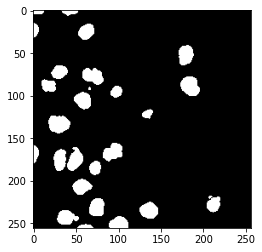

In [68]:
import matplotlib.pyplot as plt
inputs = {'images': input_save, 'gts': gts_save}
# model output
print(input_save.shape)
print(gts_save.shape)
torch.cuda.empty_cache()
loss, output = net(inputs)
pred1 = torch.argmax(output, dim=1)
pic = pred1[0] /5 * 255 
pic = pic.cpu().numpy().astype(np.uint8)
plt.imshow(pic, cmap=plt.cm.gray)


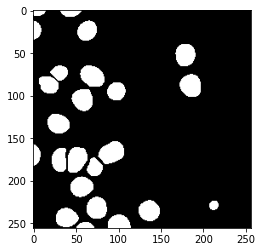

In [69]:
# gts 
pred1 = torch.argmax(gts_save, dim=1)
pic =  pred1[0] / 5 * 255
plt.imshow(pic.cpu().numpy(), cmap=plt.cm.gray)